In [19]:
import json
import os

# Đường dẫn đến thư mục dataset (điều chỉnh nếu cần thiết)
DATASET_DIR = '../../dataset_final'
PARTITIONS = ['train', 'validation', 'test']

print(f"Bắt đầu quy trình gộp file (Merge) tại: {os.path.abspath(DATASET_DIR)}\n")

for partition in PARTITIONS:
    partition_path = os.path.join(DATASET_DIR, partition)
    
    if not os.path.exists(partition_path):
        print(f"⚠️ Không tìm thấy thư mục: {partition_path}")
        continue

    # Định nghĩa đường dẫn file
    manual_path = os.path.join(partition_path, 'manual.json')
    auto_path = os.path.join(partition_path, 'auto.json')
    target_path = os.path.join(partition_path, 'labels.json')
    
    merged_data = []
    count_manual = 0
    count_auto = 0
    
    # 1. Đọc Manual Data (Ưu tiên đưa lên đầu)
    if os.path.exists(manual_path):
        try:
            with open(manual_path, 'r', encoding='utf-8') as f:
                data = json.load(f)
                if isinstance(data, list):
                    merged_data.extend(data)
                    count_manual = len(data)
        except Exception as e:
            print(f"❌ Lỗi đọc file Manual tại {partition}: {e}")

    # 2. Đọc Auto Data
    if os.path.exists(auto_path):
        try:
            with open(auto_path, 'r', encoding='utf-8') as f:
                data = json.load(f)
                if isinstance(data, list):
                    merged_data.extend(data)
                    count_auto = len(data)
        except Exception as e:
            print(f"❌ Lỗi đọc file Auto tại {partition}: {e}")
            
    # 3. Ghi ra file labels.json
    if merged_data:
        try:
            with open(target_path, 'w', encoding='utf-8') as f:
                json.dump(merged_data, f, ensure_ascii=False, indent=4)
            
            print(f"✅ [{partition.upper()}] Đã tạo 'labels.json'")
            print(f"   - Manual: {count_manual} mẫu")
            print(f"   - Auto:   {count_auto} mẫu")
            print(f"   => Tổng:  {len(merged_data)} mẫu")
        except Exception as e:
            print(f"❌ Không thể ghi file labels.json tại {partition}: {e}")
    else:
        print(f"⚠️ [{partition.upper()}] Không có dữ liệu để gộp (thiếu cả manual và auto).")

print("\n--- HOÀN TẤT QUÁ TRÌNH GỘP FILE ---")

Bắt đầu quy trình gộp file (Merge) tại: d:\Coding\School\Y3-K1\Intro2DS\DS - LAB 2\Milestone2_Project\dataset_final

✅ [TRAIN] Đã tạo 'labels.json'
   - Manual: 193 mẫu
   - Auto:   6529 mẫu
   => Tổng:  6722 mẫu
✅ [VALIDATION] Đã tạo 'labels.json'
   - Manual: 53 mẫu
   - Auto:   1074 mẫu
   => Tổng:  1127 mẫu
✅ [TEST] Đã tạo 'labels.json'
   - Manual: 45 mẫu
   - Auto:   767 mẫu
   => Tổng:  812 mẫu

--- HOÀN TẤT QUÁ TRÌNH GỘP FILE ---


In [ ]:
import json
import os
import re
import pandas as pd
import numpy as np

# Đường dẫn dataset
DATASET_DIR = '../../dataset_final'
PARTITIONS = ['train', 'validation', 'test']

# --- 1. TỐI ƯU REGEX (Pre-compile patterns) ---
# Biên dịch mẫu Regex 1 lần duy nhất để tái sử dụng -> Tăng tốc cực đại
# Pattern giải thích: Tìm key, theo sau là dấu =, rồi đến dấu { hoặc ", lấy nội dung bên trong (non-greedy), kết thúc bằng } hoặc "
# (?<!\\) để tránh match nhầm dấu đóng bị escape (ví dụ \})
P_TITLE = re.compile(r'title\s*=\s*[\{"](.*?)(?<!\\)[\}"]', re.IGNORECASE | re.DOTALL)
P_AUTHOR = re.compile(r'author\s*=\s*[\{"](.*?)(?<!\\)[\}"]', re.IGNORECASE | re.DOTALL)
# Pattern clean nhanh dấu ngoặc nhọn và khoảng trắng thừa
P_CLEAN_BRACES = re.compile(r'[\{\}]')
P_CLEAN_SPACES = re.compile(r'\s+')

def parse_bibtex_fast(bib_string):
    """
    Hàm parse siêu tốc chỉ dùng Regex đã biên dịch sẵn.
    """
    if not isinstance(bib_string, str) or not bib_string:
        return '', ''

    # Tìm Title
    m_title = P_TITLE.search(bib_string)
    raw_title = m_title.group(1) if m_title else ''
    
    # Tìm Author
    m_author = P_AUTHOR.search(bib_string)
    raw_author = m_author.group(1) if m_author else ''
    
    # Clean nhanh (Xóa dấu {}, thay nhiều khoảng trắng bằng 1 khoảng trắng)
    # Lưu ý: Nếu chuỗi rỗng thì skip luôn cho nhanh
    if raw_title:
        # Thay thế nhanh: title.replace('{', '').replace('}', '') nhanh hơn regex sub đơn giản
        parsed_title = " ".join(raw_title.replace('{', '').replace('}', '').split())
    else:
        parsed_title = ''
        
    if raw_author:
        parsed_author = " ".join(raw_author.replace('{', '').replace('}', '').split())
    else:
        parsed_author = ''
        
    return parsed_title, parsed_author

# --- LOGIC DEDUPLICATE LIST ---
def deduplicate_list(input_list):
    if not isinstance(input_list, list) or not input_list: return []
    # dict.fromkeys() là cách nhanh nhất để dedupe giữ order trong Python hiện đại
    return list(dict.fromkeys([str(x).strip() for x in input_list if str(x).strip()]))

stats = []
all_samples_list = []

print("Dang tai va xu ly du lieu (FAST MODE)...")

for partition in PARTITIONS:
    partition_path = os.path.join(DATASET_DIR, partition)
    
    for file_type in ['manual.json', 'auto.json']:
        file_path = os.path.join(partition_path, file_type)
        
        if os.path.exists(file_path):
            try:
                with open(file_path, 'r', encoding='utf-8') as f:
                    data = json.load(f)
                    
                count_loaded = 0
                
                # Duyệt qua từng item
                for item in data:
                    # 1. Validate Ground Truth
                    gt = item.get('ground_truth')
                    if not gt: continue 
                    
                    gt_authors = gt.get('authors')
                    if not isinstance(gt_authors, list): gt_authors = []
                    
                    # Deduplicate authors (nhanh)
                    if gt_authors:
                        gt_authors = deduplicate_list(gt_authors)
                    
                    # Nếu sau khi dedupe mà rỗng -> Bỏ qua
                    if not gt_authors: continue 

                    # Xử lý lấy năm từ Ground Truth (Metadata)
                    gt_date = gt.get('submission_date', '')
                    gt_year = ''
                    # submission_date thường có dạng "2023-02-23..." -> Lấy 4 ký tự đầu
                    if gt_date and len(str(gt_date)) >= 4:
                        gt_year = str(gt_date)[:4]

                    # 2. Parse BibTeX (FAST MODE)
                    bib_content = item.get('content', '')
                    p_title, p_author = parse_bibtex_fast(bib_content)
                    
                    # 3. Append row (nhanh gọn, dict literal)
                    all_samples_list.append({
                        'partition': partition,
                        'source_type': file_type.replace('.json', ''),
                        'key': item.get('key'),
                        'paper_id': gt.get('id', 'unknown'),
                        'bib_content': bib_content,
                        'bib_title': p_title,
                        'bib_author': p_author,
                        'gt_id': gt.get('id'),
                        'gt_title': gt.get('title', ''),
                        'gt_authors': gt_authors,
                        'gt_year': gt_year
                    })
                    count_loaded += 1
                
                stats.append({
                    'partition': partition,
                    'type': file_type.replace('.json', ''),
                    'sample_count': count_loaded,
                    'status': 'Loaded'
                })
                    
            except Exception as e:
                print(f"Lỗi đọc file {file_path}: {e}")
                stats.append({'partition': partition, 'type': file_type, 'sample_count': 0, 'status': 'Error'})
        else:
            stats.append({'partition': partition, 'type': file_type, 'sample_count': 0, 'status': 'Missing'})

# --- KẾT QUẢ ---
df_all = pd.DataFrame(all_samples_list)
print(f"\n--- TỔNG HỢP (FAST MODE) ---")
print(f"Tổng số mẫu sạch đã load: {len(df_all)}")

# Check nhanh
missing_parse = df_all[df_all['bib_title'] == ''].shape[0]
print(f"Số mẫu không parse được Title: {missing_parse}")

Dang tai va xu ly du lieu (FAST MODE)...

--- TỔNG HỢP (FAST MODE) ---
Tổng số mẫu sạch đã load: 8658
Số mẫu không parse được Title: 6826


In [21]:
import numpy as np

def check_data_quality(df):
    print("=== BÁO CÁO CHẤT LƯỢNG DỮ LIỆU CHI TIẾT ===")
    
    # 1. Kiểm tra Ground Truth (Labels)
    # Kiểm tra Title
    missing_gt_title = df[df['gt_title'].str.strip() == ''].shape[0]
    print(f"❌ Ground Truth thiếu Title: {missing_gt_title} mẫu")
    
    # Kiểm tra Authors (List rỗng hoặc None)
    # Lưu ý: gt_authors trong df_all đang là list (do code load ở trên)
    empty_gt_authors = df[df['gt_authors'].apply(lambda x: len(x) == 0 if isinstance(x, list) else True)].shape[0]
    print(f"❌ Ground Truth thiếu Authors: {empty_gt_authors} mẫu")

    # 2. Kiểm tra BibTeX Content (Input)
    # Kiểm tra xem có parse được Title và Author từ chuỗi BibTeX gốc không
    missing_bib_title = df[df['bib_title'].str.strip() == ''].shape[0]
    missing_bib_author = df[df['bib_author'].str.strip() == ''].shape[0]
    
    print(f"⚠️ Không parse được Title từ BibTeX: {missing_bib_title} mẫu")
    print(f"⚠️ Không parse được Author từ BibTeX: {missing_bib_author} mẫu")
    
    def has_duplicate_authors(auth_list):
        if not isinstance(auth_list, list) or len(auth_list) == 0:
            return False
        # Chuẩn hóa tên đơn giản để check trùng (bỏ khoảng trắng thừa)
        clean_list = [str(a).strip() for a in auth_list]
        return len(clean_list) != len(set(clean_list))

    duplicate_authors_count = df['gt_authors'].apply(has_duplicate_authors).sum()
    print(f"ℹ️ Cảnh báo: {duplicate_authors_count} mẫu có tác giả bị trùng lặp trong Ground Truth (Data Cleaning cần xử lý).")

    # 4. Hiển thị các dòng bị lỗi (nếu có) để review
    error_mask = (df['gt_title'].str.strip() == '') | \
                 (df['gt_authors'].apply(lambda x: len(x) == 0)) | \
                 (df['bib_title'].str.strip() == '')
    
    if error_mask.sum() > 0:
        print("\n--- MẪU DỮ LIỆU BỊ THIẾU THÔNG TIN ---")
        display(df[error_mask][['paper_id', 'key', 'gt_title', 'bib_title']].head())
    else:
        print("\n✅ Không tìm thấy mẫu dữ liệu nào bị thiếu thông tin nghiêm trọng.")

# Chạy hàm kiểm tra trên DataFrame tổng đã tạo ở bước trước
if 'df_all' in locals():
    check_data_quality(df_all)
else:
    print("Vui lòng chạy cell load dữ liệu (df_all) trước.")

=== BÁO CÁO CHẤT LƯỢNG DỮ LIỆU CHI TIẾT ===
❌ Ground Truth thiếu Title: 0 mẫu
❌ Ground Truth thiếu Authors: 0 mẫu
⚠️ Không parse được Title từ BibTeX: 6826 mẫu
⚠️ Không parse được Author từ BibTeX: 6826 mẫu
ℹ️ Cảnh báo: 0 mẫu có tác giả bị trùng lặp trong Ground Truth (Data Cleaning cần xử lý).

--- MẪU DỮ LIỆU BỊ THIẾU THÔNG TIN ---


,paper_id,key,gt_title,bib_title
193,2010-03748,ref_0,On the arithmetic-geometric index of graphs,
194,2010-03748,ref_1,On the arithmetic-geometric index of graphs,
195,2010-03748,ref_2,On the arithmetic-geometric index of graphs,
196,2010-03748,ref_3,On the arithmetic-geometric index of graphs,
197,2010-03748,ref_8,On the arithmetic-geometric index of graphs,


# 4. NLP Pipeline EDA: Deep Dive into Text Quality

Phân tích này giúp định hướng cho bước Data Cleaning và Feature Engineering.
Chúng ta sẽ kiểm tra:
1. **Phân bố độ dài (Length Distribution):** So sánh độ dài chuỗi BibTeX vs Ground Truth.
2. **Phân tích nhiễu (Noise Analysis):** Đếm các ký tự đặc biệt của LaTeX còn sót lại.
3. **Baseline Similarity:** Đo lường độ tương đồng tự nhiên giữa các cặp đúng.


C:\Users\duyla\AppData\Local\Temp\ipykernel_33400\48153437.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df_eda['latex_noise'], ax=axes[1, 0], palette="viridis")


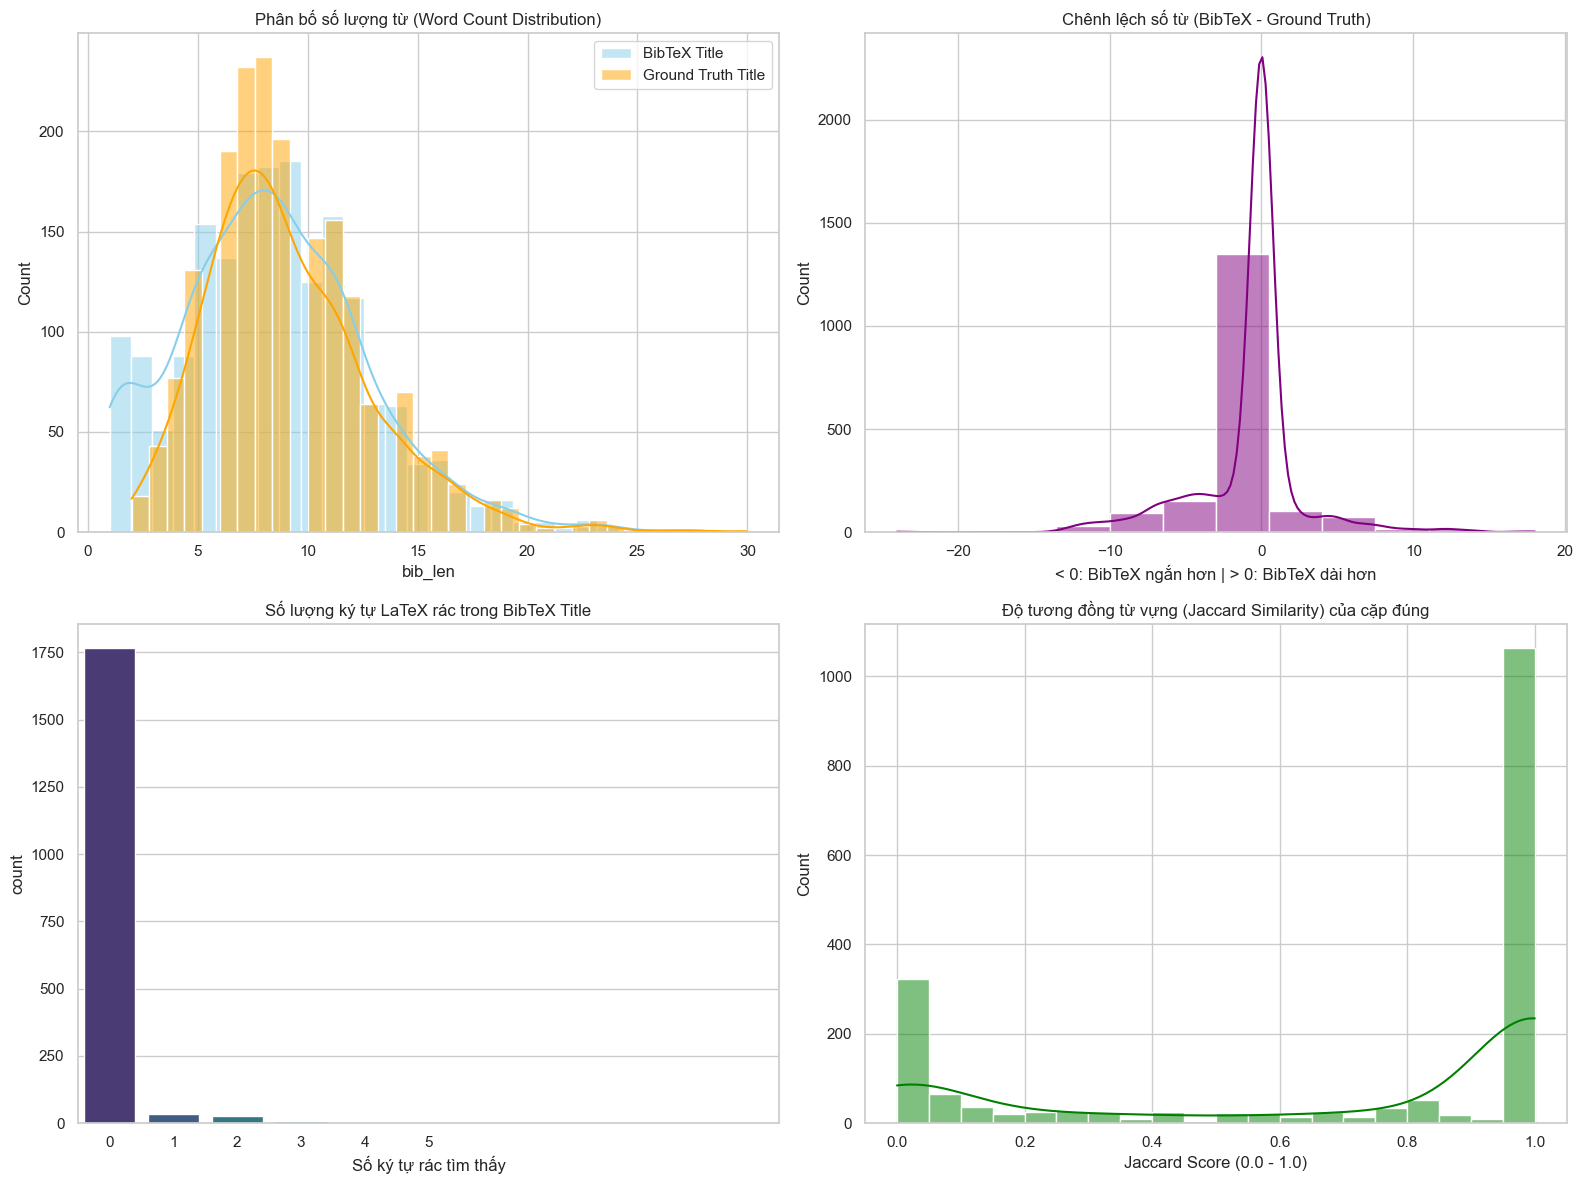


=== NLP EDA SUMMARY REPORT ===
1. Độ dài trung bình (từ): BibTeX = 8.4 | Ground Truth = 9.1
2. Số mẫu bị nhiễm mã LaTeX (>0 ký tự rác): 67 (3.7%)
3. Jaccard Similarity trung bình: 0.691

--- TOP 3 MẪU CÓ TITLE BIBTEX QUÁ NGẮN SO VỚI THỰC TẾ (Có thể do lỗi Parse) ---
BibTeX: The MALATANG Survey: The L $_GAS
Real:   The MALATANG Survey: The LGAS–LIR Correlation on Sub-kiloparsec Scale in Six Nearby Star-forming Galaxies as Traced by HCN J = 4 → 3 and HCO+ J = 4 → 3
------------------------------
BibTeX: The 300-pc scale ALMA view of [C I] $^3
Real:   The 300-pc scale ALMA view of [C i] 3P1–3P0, CO J = 1–0, and 609-μm dust continuum in a luminous infrared galaxy
------------------------------
BibTeX: CulturaX
Real:   CulturaX: A Cleaned, Enormous, and Multilingual Dataset for Large Language Models in 167 Languages
------------------------------


In [22]:

# %%
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
from collections import Counter

# Cấu hình hiển thị
sns.set(style="whitegrid", context="notebook")
plt.rcParams['figure.figsize'] = (14, 10)

# Lấy dữ liệu sạch để phân tích
# Lưu ý: Chỉ phân tích trên tập dữ liệu đã parse thành công title
df_eda = df_all[df_all['bib_title'].str.len() > 0].copy()

# --- 1. PHÂN TÍCH ĐỘ DÀI (LENGTH DISTRIBUTION) ---
# Tại sao quan trọng? Nếu BibTeX Title luôn ngắn hơn GT Title, có thể regex parse bị lỗi cắt chuỗi.

# Tính độ dài số từ (Word Count)
df_eda['bib_len'] = df_eda['bib_title'].apply(lambda x: len(str(x).split()))
df_eda['gt_len'] = df_eda['gt_title'].apply(lambda x: len(str(x).split()))

# Tính sự chênh lệch độ dài
df_eda['len_diff'] = df_eda['bib_len'] - df_eda['gt_len']

# Vẽ biểu đồ
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Biểu đồ 1: Phân bố số từ
sns.histplot(df_eda['bib_len'], color='skyblue', label='BibTeX Title', kde=True, ax=axes[0, 0])
sns.histplot(df_eda['gt_len'], color='orange', label='Ground Truth Title', kde=True, ax=axes[0, 0])
axes[0, 0].set_title('Phân bố số lượng từ (Word Count Distribution)')
axes[0, 0].legend()

# Biểu đồ 2: Sự chênh lệch (Bib - GT)
sns.histplot(df_eda['len_diff'], color='purple', kde=True, ax=axes[0, 1])
axes[0, 1].set_title('Chênh lệch số từ (BibTeX - Ground Truth)')
axes[0, 1].set_xlabel('< 0: BibTeX ngắn hơn | > 0: BibTeX dài hơn')

# --- 2. PHÂN TÍCH NHIỄU LATEX (NOISE ANALYSIS) ---
# Tại sao quan trọng? Để biết cần dùng Regex mạnh tay cỡ nào ở bước Cleaning.

def count_latex_artifacts(text):
    if not isinstance(text, str): return 0
    # Đếm các ký tự đặc trưng của LaTeX: \, {, }, $, \it, ...
    return len(re.findall(r'[\{\}\$\\]', text))

df_eda['latex_noise'] = df_eda['bib_title'].apply(count_latex_artifacts)

# Biểu đồ 3: Mức độ nhiễm bẩn LaTeX
sns.countplot(x=df_eda['latex_noise'], ax=axes[1, 0], palette="viridis")
axes[1, 0].set_title('Số lượng ký tự LaTeX rác trong BibTeX Title')
axes[1, 0].set_xlabel('Số ký tự rác tìm thấy')
axes[1, 0].set_xlim(-0.5, 10.5) # Chỉ hiển thị khoảng đầu

# --- 3. BASELINE SIMILARITY (JACCARD) ---
# Tại sao quan trọng? Đây là feature quan trọng nhất. Nếu biểu đồ này lệch về 1.0 -> Bài toán dễ.

def simple_jaccard(row):
    s1 = set(str(row['bib_title']).lower().split())
    s2 = set(str(row['gt_title']).lower().split())
    if not s1 or not s2: return 0.0
    return len(s1.intersection(s2)) / len(s1.union(s2))

df_eda['jaccard_sim'] = df_eda.apply(simple_jaccard, axis=1)

# Biểu đồ 4: Phân bố độ tương đồng Jaccard
sns.histplot(df_eda['jaccard_sim'], bins=20, color='green', kde=True, ax=axes[1, 1])
axes[1, 1].set_title('Độ tương đồng từ vựng (Jaccard Similarity) của cặp đúng')
axes[1, 1].set_xlabel('Jaccard Score (0.0 - 1.0)')

plt.tight_layout()
plt.show()

# --- BÁO CÁO TEXT STATISTICS ---
print("\n=== NLP EDA SUMMARY REPORT ===")
print(f"1. Độ dài trung bình (từ): BibTeX = {df_eda['bib_len'].mean():.1f} | Ground Truth = {df_eda['gt_len'].mean():.1f}")
print(f"2. Số mẫu bị nhiễm mã LaTeX (>0 ký tự rác): {df_eda[df_eda['latex_noise'] > 0].shape[0]} ({df_eda[df_eda['latex_noise'] > 0].shape[0]/len(df_eda)*100:.1f}%)")
print(f"3. Jaccard Similarity trung bình: {df_eda['jaccard_sim'].mean():.3f}")

# Kiểm tra các trường hợp dị biệt (Outliers)
print("\n--- TOP 3 MẪU CÓ TITLE BIBTEX QUÁ NGẮN SO VỚI THỰC TẾ (Có thể do lỗi Parse) ---")
short_outliers = df_eda[df_eda['len_diff'] < -5].sort_values('len_diff').head(3)
if not short_outliers.empty:
    for idx, row in short_outliers.iterrows():
        print(f"BibTeX: {row['bib_title']}")
        print(f"Real:   {row['gt_title']}")
        print("-" * 30)
else:
    print("Không phát hiện lỗi cắt chuỗi nghiêm trọng.")

In [23]:
!pip install pylatexenc fuzzywuzzy

In [24]:
import bibtexparser
from pylatexenc.latex2text import LatexNodes2Text
import re
import pandas as pd

# --- CẤU HÌNH CLEANER ---
latex_decoder = LatexNodes2Text()

# Pre-compile Regex cho nhanh
# Regex 1: Tìm key year chuẩn: year = {2020} hoặc year = "2020" hoặc year = 2020
P_YEAR_KEY = re.compile(r'year\s*=\s*[\{\"]?\s*([12]\d{3})\s*[\}\"]?', re.IGNORECASE)
# Regex 2: Tìm số năm trơ trọi (Last resort)
P_YEAR_SIMPLE = re.compile(r'\b(19|20)\d{2}\b')

def clean_latex(text):
    if not isinstance(text, str) or not text: return ""
    try:
        text = latex_decoder.latex_to_text(text)
        text = text.replace('{', '').replace('}', '')
        text = " ".join(text.split())
        return text
    except:
        return text

def normalize_id(text):
    if not text: return ""
    return re.sub(r'[\.\-\/]', '', str(text).lower())

def parse_bib_content_smart(bib_string):
    """
    Phiên bản V3: Ưu tiên cấu trúc year={} trước, tránh bắt nhầm năm trong Note/Erratum.
    """
    if not bib_string: return {}, "empty"

    parsed_data = {
        "title": "",
        "authors": [],
        "year": "",
        "extracted_id": ""
    }
    
    # --- BƯỚC 1: QUAN TRỌNG NHẤT - TÌM NĂM DỰA TRÊN KEY-VALUE ---
    # Chạy regex tìm "year = {xxxx}" TRƯỚC. 
    # Việc này xử lý được cả case @misc{ text={@article{... year={2012} ...}} } 
    # mà không cần parse cấu trúc phức tạp.
    year_match = P_YEAR_KEY.search(bib_string)
    if year_match:
        parsed_data['year'] = year_match.group(1)

    # --- BƯỚC 2: PARSE CẤU TRÚC (BIBTEX PARSER) ---
    # Dù đã tìm được năm hay chưa, vẫn cần parse để lấy Title/Author chuẩn
    if bib_string.strip().startswith('@'):
        try:
            parser = bibtexparser.bparser.BibTexParser(common_strings=True)
            # ignore_nonstandard_types=False giúp parse được cả các thẻ lạ
            bib_db = bibtexparser.loads(bib_string, parser=parser)
            
            if bib_db.entries:
                entry = bib_db.entries[0]
                
                # Title
                parsed_data['title'] = clean_latex(entry.get('title', ''))
                
                # Author
                raw_authors = entry.get('author', '')
                if raw_authors:
                    parsed_data['authors'] = [clean_latex(a.strip()) for a in raw_authors.split(' and ')]
                
                # ID
                raw_id = entry.get('eprint', entry.get('doi', ''))
                parsed_data['extracted_id'] = normalize_id(raw_id)
                
                # Nếu Bước 1 chưa bắt được năm (do format lạ), thử lấy từ parser
                if not parsed_data['year']:
                    parsed_data['year'] = entry.get('year', '')
                
                return parsed_data, "bibtex_struct"
        except:
            pass # Fallback xuống dưới

    # --- BƯỚC 3: XỬ LÝ UNSTRUCTURED TEXT ---
    if r'\newblock' in bib_string:
        try:
            parts = bib_string.split(r'\newblock')
            
            # Author
            raw_author_str = parts[0].strip()
            if raw_author_str.endswith('.'): raw_author_str = raw_author_str[:-1]
            parsed_data['authors'] = [clean_latex(a.strip()) for a in raw_author_str.split(',')]

            # Title
            if len(parts) > 1:
                parsed_data['title'] = clean_latex(parts[1].strip())
            
            # Năm trong flat text thường nằm ở cuối câu, ví dụ: "... Journal Name, 2020."
            # Chỉ tìm nếu Bước 1 chưa có
            if not parsed_data['year']:
                # Tìm ở đoạn cuối cùng của chuỗi
                last_part = parts[-1]
                simple_match = P_YEAR_SIMPLE.search(last_part)
                if simple_match:
                    parsed_data['year'] = simple_match.group(0)

            return parsed_data, "flat_text"
        except:
            pass
            
    # --- BƯỚC 4: FALLBACK REGEX TITLE & ID ---
    # (Cho trường hợp không parse được cấu trúc nhưng vẫn muốn vớt vát)
    if not parsed_data['title']:
        title_match = re.search(r'title\s*=\s*[\{"](.*?)(?<!\\)[\}"]', bib_string, re.IGNORECASE | re.DOTALL)
        if title_match:
            parsed_data['title'] = clean_latex(title_match.group(1))

    # --- BƯỚC 5: LAST RESORT FOR YEAR ---
    # Nếu tất cả các bước trên đều không tìm thấy năm, 
    # lúc này mới chấp nhận tìm số 4 chữ số bất kỳ (chấp nhận rủi ro)
    if not parsed_data['year']:
        fallback_match = P_YEAR_SIMPLE.search(bib_string)
        if fallback_match:
            parsed_data['year'] = fallback_match.group(0)

    return parsed_data, "regex_fallback"

In [25]:

# --- 3. ÁP DỤNG VÀO DATAFRAME ---
print("Đang xử lý làm sạch dữ liệu (Detailed Parsing)...")

# Apply hàm parse cho từng dòng
# Lưu ý: df_all lấy từ bước trước
extracted_info = df_all['bib_content'].apply(parse_bib_content_smart)

# Tách kết quả từ tuple trả về
df_all['clean_data'] = extracted_info.apply(lambda x: x[0])
df_all['parse_method'] = extracted_info.apply(lambda x: x[1])

# Bung các trường dữ liệu ra cột riêng để dễ dùng
df_all['clean_title'] = df_all['clean_data'].apply(lambda x: x.get('title', ''))
df_all['clean_authors'] = df_all['clean_data'].apply(lambda x: x.get('authors', []))
df_all['clean_id'] = df_all['clean_data'].apply(lambda x: x.get('extracted_id', ''))
df_all['clean_year'] = df_all['clean_data'].apply(lambda x: x.get('year', ''))

# --- 4. KIỂM TRA KẾT QUẢ TRÊN CÁC TRƯỜNG HỢP KHÓ ---
print("\n=== KIỂM TRA MẪU DỮ LIỆU ĐẶC BIỆT ===")

# Test case 1: BibTeX chuẩn với LaTeX noise (Ref_47 của bạn)
print("--- [Test 1] Structured BibTeX with LaTeX Noise ---")
sample_struct = df_all[df_all['bib_content'].str.contains("sNN", na=False)].head(1)
if not sample_struct.empty:
    r = sample_struct.iloc[0]
    print(f"Original:\n{r['bib_content'][:100]}...")
    print(f"Parsed Title:   {r['clean_title']}") # Kỳ vọng: ... 5–200 GeV ... (mất \textendash)
    print(f"Parsed ID:      {r['clean_id']}")    # Kỳ vọng: 190909304
    print(f"Parsed Method:  {r['parse_method']}")
    print(f"clean year:  {r['clean_year']}")

# Test case 2: Unstructured Text (\newblock)
print("\n--- [Test 2] Unstructured Text (Flat Citation) ---")
sample_flat = df_all[df_all['bib_content'].str.contains("newblock", na=False)].head(1)
if not sample_flat.empty:
    r = sample_flat.iloc[0]
    print(f"Original:\n{r['bib_content'][:100]}...")
    print(f"Parsed Title:   {r['clean_title']}")
    print(f"Parsed Authors: {r['clean_authors']}")
    print(f"Parsed Method:  {r['parse_method']}")
    print(f"clean year:  {r['clean_year']}")

print(f"\n✅ Đã xử lý xong. Số lượng Parse theo từng loại:")
print(df_all['parse_method'].value_counts())

Đang xử lý làm sạch dữ liệu (Detailed Parsing)...

=== KIỂM TRA MẪU DỮ LIỆU ĐẶC BIỆT ===
--- [Test 1] Structured BibTeX with LaTeX Noise ---
Original:
@article{48,
note = {[Erratum: Phys.Lett.B 829, 137132 (2022)]},
year = {2020},
pages = {135452},
vo...
Parsed Title:   Light nuclei production in Au+Au collisions at sNN = 5–200 GeV from JAM model
Parsed ID:      190909304
Parsed Method:  bibtex_struct
clean year:  2020

--- [Test 2] Unstructured Text (Flat Citation) ---
Original:
{\sc Aouchiche, M., Hallaoui, I.~E., and Hansen, P.} \newblock Geometric-arithmetic index and minimu...
Parsed Title:   Geometric-arithmetic index and minimum degree of connected graphs.
Parsed Authors: ['Aouchiche', 'M.', 'Hallaoui', 'I. E.', 'and Hansen', 'P.']
Parsed Method:  flat_text
clean year:  2020

✅ Đã xử lý xong. Số lượng Parse theo từng loại:
parse_method
flat_text         4001
regex_fallback    2825
bibtex_struct     1832
Name: count, dtype: int64


In [26]:
df_all.head()

,partition,source_type,key,paper_id,bib_content,bib_title,bib_author,gt_id,gt_title,gt_authors,clean_data,parse_method,clean_title,clean_authors,clean_id,clean_year
0,train,manual,ref_1,1710-04050,"@article{Adebahr2017,\nadsnote = {Provided by ...",M 82 - A radio continuum and polarisation stud...,Adebahr,1710-04050,M82 - A radio continuum and polarisation study...,"[B. Adebahr, M. Krause, Uli Klein, G. Heald, R...",{'title': 'M 82 - A radio continuum and polari...,bibtex_struct,M 82 - A radio continuum and polarisation stud...,"[Adebahr, B., Krause, M., Klein, U., Heald, G....",171004050,2017
1,train,manual,ref_2,1502-05050,"@article{Balbinot2015,\nadsnote = {Provided by...",The LMC geometry and outer stellar populations...,Balbinot,1502-05050,The LMC geometry and outer stellar populations...,"[E. Balbinot, B. Santiago, L. Girardi, A. Pier...",{'title': 'The LMC geometry and outer stellar ...,bibtex_struct,The LMC geometry and outer stellar populations...,"[Balbinot, Eduardo, Santiago, B. X., Girardi, ...",150205050,2015
2,train,manual,ref_4,1509-04522,"@article{Beck2015,\nadsnote = {Provided by the...",Magnetic fields in spiral galaxies,Beck,1509-04522,Magnetic fields in spiral galaxies,[R. Beck],{'title': 'Magnetic fields in spiral galaxies'...,bibtex_struct,Magnetic fields in spiral galaxies,"[Beck, Rainer]",150904522,2015
3,train,manual,ref_5,1912-08962,"@article{Beck2019,\nadsnote = {Provided by the...",Synthesizing Observations and Theory to Unders...,Beck,1912-08962,Synthesizing Observations and Theory to Unders...,"[R. Beck, L. Chamandy, E. Elson, E. Blackman]",{'title': 'Synthesizing Observations and Theor...,bibtex_struct,Synthesizing Observations and Theory to Unders...,"[Beck, Rainer, Chamandy, Luke, Elson, Ed, Blac...",191208962,2019
4,train,manual,ref_7,1604-05316,"@article{Bigiel2016,\nadsnote = {Provided by t...",The EMPIRE Survey: Systematic Variations in th...,Bigiel,1604-05316,THE EMPIRE SURVEY: SYSTEMATIC VARIATIONS IN TH...,"[F. Bigiel, A. Leroy, M. Jiménez-Donaire, J. P...",{'title': 'The EMPIRE Survey: Systematic Varia...,bibtex_struct,The EMPIRE Survey: Systematic Variations in th...,"[Bigiel, Frank, Leroy, Adam K., Jiménez-Donair...",160405316,2016


Đang phân tích trên 5833 mẫu dữ liệu đã làm sạch...


C:\Users\duyla\AppData\Local\Temp\ipykernel_33400\1539670835.py:78: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=id_counts.index, y=id_counts.values, palette='viridis', ax=axes[1,0])


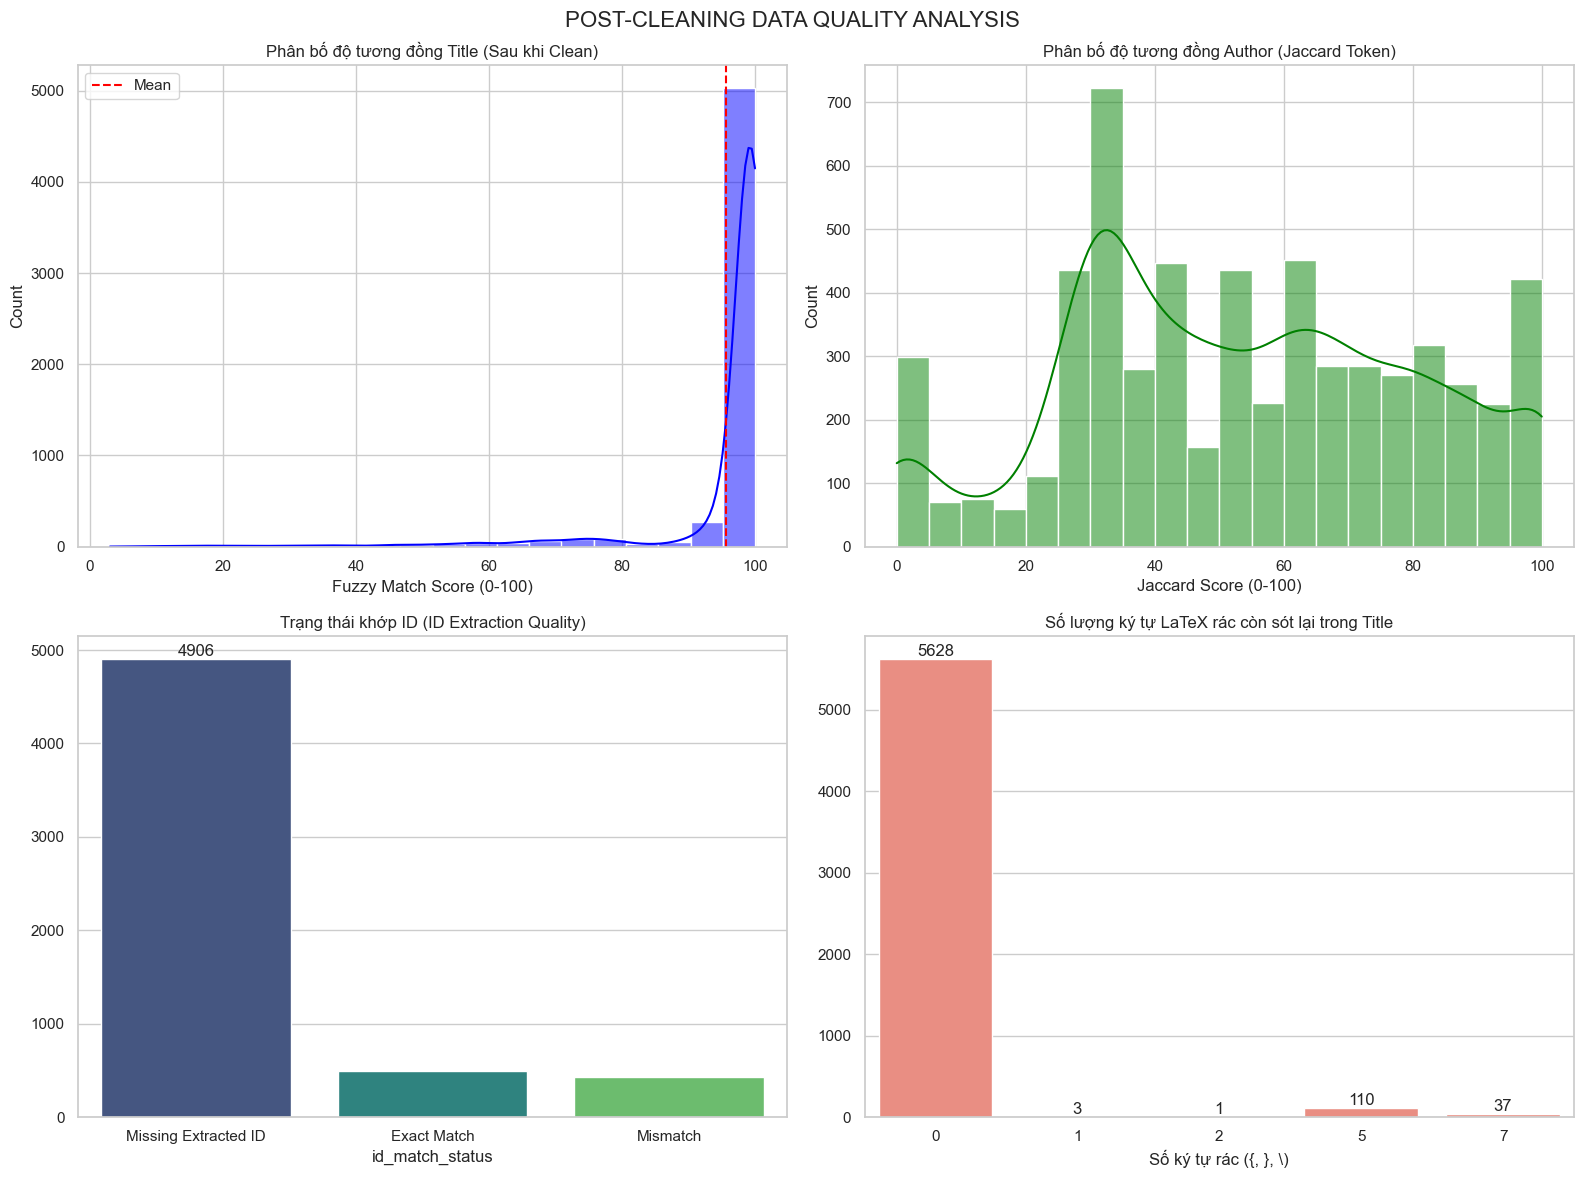

=== SUMMARY REPORT ===
1. Trung bình Title Score:  95.70/100
2. Trung bình Author Score: 53.38/100
3. Tỷ lệ khớp ID chính xác: 8.50%
4. Số mẫu còn dính rác LaTeX: 205 mẫu

=== KIỂM TRA LẠI MẪU CÓ KÝ TỰ ĐẶC BIỆT (REF_47) ===
Clean Title: Light nuclei production in Au+Au collisions at sNN = 5–200 GeV from JAM model
GT Title:    Light nuclei production in Au+Au collisions at sNN = 5–200 GeV from JAM model
Score:       100


In [27]:
# %%
import matplotlib.pyplot as plt
import seaborn as sns
from fuzzywuzzy import fuzz
import numpy as np

# --- 1. CHUẨN BỊ DỮ LIỆU EDA ---
# Chỉ lấy các dòng đã parse thành công để phân tích
df_clean_eda = df_all[df_all['clean_title'] != ""].copy()

print(f"Đang phân tích trên {len(df_clean_eda)} mẫu dữ liệu đã làm sạch...")

# --- 2. TÍNH TOÁN CÁC METRICS (CHỈ SỐ ĐÁNH GIÁ) ---

# A. Title Similarity (Dùng Levenshtein Ratio - Tốt cho việc bắt lỗi chính tả/format)
# fuzz.ratio so sánh độ khớp 1-1 giữa 2 chuỗi
df_clean_eda['title_score'] = df_clean_eda.apply(
    lambda x: fuzz.ratio(x['clean_title'].lower(), x['gt_title'].lower()), axis=1
)

# B. Author Similarity (Jaccard trên tập hợp tên)
def calculate_author_jaccard(row):
    # Chuyển list tác giả thành set các từ đơn lẻ (tokens) để bỏ qua thứ tự
    # VD: ["Liu, Hui"] -> {"liu", "hui"}
    bib_tokens = set(" ".join(row['clean_authors']).lower().replace(',', '').split())
    
    # Ground truth authors cũng cần xử lý tương tự
    gt_list = row['gt_authors'] if isinstance(row['gt_authors'], list) else []
    gt_tokens = set(" ".join(gt_list).lower().replace(',', '').split())
    
    if not bib_tokens or not gt_tokens: return 0.0
    
    intersection = bib_tokens.intersection(gt_tokens)
    union = bib_tokens.union(gt_tokens)
    return len(intersection) / len(union) * 100 # Quy về thang 100

df_clean_eda['author_score'] = df_clean_eda.apply(calculate_author_jaccard, axis=1)

# C. ID Matching (Golden Feature Check)
# Kiểm tra xem ID trích xuất được có khớp với ID thật không
def check_id_match(row):
    extracted = str(row['clean_id']).strip()
    ground_truth = str(row['gt_id']).strip().replace('.', '').replace('-', '').lower() # Chuẩn hóa GT ID
    
    if not extracted: return "Missing Extracted ID"
    if extracted == ground_truth: return "Exact Match"
    if extracted in ground_truth: return "Partial Match" # VD: doi nằm trong string dài
    return "Mismatch"

df_clean_eda['id_match_status'] = df_clean_eda.apply(check_id_match, axis=1)

# D. Kiểm tra tàn dư LaTeX (Residual Noise)
def count_residual_latex(text):
    # Đếm các ký tự đặc biệt còn sót: \, {, }
    return len(re.findall(r'[\\\{\}]', text))

df_clean_eda['residual_noise'] = df_clean_eda['clean_title'].apply(count_residual_latex)


# --- 3. TRỰC QUAN HÓA KẾT QUẢ (VISUALIZATION) ---
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
plt.suptitle('POST-CLEANING DATA QUALITY ANALYSIS', fontsize=16)

# Plot 1: Phân bố điểm Title Similarity
sns.histplot(df_clean_eda['title_score'], bins=20, kde=True, color='blue', ax=axes[0,0])
axes[0,0].set_title('Phân bố độ tương đồng Title (Sau khi Clean)')
axes[0,0].set_xlabel('Fuzzy Match Score (0-100)')
axes[0,0].axvline(df_clean_eda['title_score'].mean(), color='red', linestyle='--', label='Mean')
axes[0,0].legend()

# Plot 2: Phân bố điểm Author Similarity
sns.histplot(df_clean_eda['author_score'], bins=20, kde=True, color='green', ax=axes[0,1])
axes[0,1].set_title('Phân bố độ tương đồng Author (Jaccard Token)')
axes[0,1].set_xlabel('Jaccard Score (0-100)')

# Plot 3: Hiệu quả trích xuất ID (Golden Feature)
id_counts = df_clean_eda['id_match_status'].value_counts()
sns.barplot(x=id_counts.index, y=id_counts.values, palette='viridis', ax=axes[1,0])
axes[1,0].set_title('Trạng thái khớp ID (ID Extraction Quality)')
axes[1,0].bar_label(axes[1,0].containers[0])

# Plot 4: Kiểm tra sạch nhiễu (Residual Noise)
# So sánh số lượng mẫu còn dính nhiễu vs mẫu sạch
noise_counts = df_clean_eda['residual_noise'].value_counts().sort_index().head(5) # Chỉ lấy 5 mức đầu
sns.barplot(x=noise_counts.index, y=noise_counts.values, color='salmon', ax=axes[1,1])
axes[1,1].set_title('Số lượng ký tự LaTeX rác còn sót lại trong Title')
axes[1,1].set_xlabel('Số ký tự rác ({, }, \)')
axes[1,1].bar_label(axes[1,1].containers[0])

plt.tight_layout()
plt.show()

# --- 4. BÁO CÁO TỔNG HỢP ---
print("=== SUMMARY REPORT ===")
print(f"1. Trung bình Title Score:  {df_clean_eda['title_score'].mean():.2f}/100")
print(f"2. Trung bình Author Score: {df_clean_eda['author_score'].mean():.2f}/100")
print(f"3. Tỷ lệ khớp ID chính xác: {(df_clean_eda['id_match_status'] == 'Exact Match').mean() * 100:.2f}%")
print(f"4. Số mẫu còn dính rác LaTeX: {(df_clean_eda['residual_noise'] > 0).sum()} mẫu")

# --- 5. CHECK LẠI TRƯỜNG HỢP REF_47 CỤ THỂ ---
print("\n=== KIỂM TRA LẠI MẪU CÓ KÝ TỰ ĐẶC BIỆT (REF_47) ===")
# Tìm mẫu có chứa "5-200" (đã clean) hoặc "5\textendash" (chưa clean)
special_sample = df_clean_eda[df_clean_eda['clean_title'].str.contains("5–200|5-200", regex=True)].head(1)
if not special_sample.empty:
    row = special_sample.iloc[0]
    print(f"Clean Title: {row['clean_title']}")
    print(f"GT Title:    {row['gt_title']}")
    print(f"Score:       {row['title_score']}")
else:
    print("Không tìm thấy mẫu ref_47 cụ thể (có thể do lấy mẫu hoặc regex title khác).")


### 1. Phân tích chi tiết (Deep Dive Insights)

#### Điểm sáng (Wins)

* **Chiến lược Clean Title cực kỳ thành công (Title Score ~96/100):**
* Nhìn vào biểu đồ góc trên bên trái (*Title Similarity*), cột dữ liệu dồn hẳn về phía 90-100 điểm. Đường màu đỏ (Mean) đạt **95.71**.
* Trường hợp `ref_47` đạt 100/100 chứng minh rằng `LatexNodes2Text` đã xử lý hoàn hảo các ký tự khó như `\textendash` (dấu gạch ngang) hay công thức toán học.
* **Hệ quả:** Feature `title_similarity` sẽ là đặc trưng **mạnh nhất (dominant feature)** để mô hình phân loại.


* **Dữ liệu rất sạch (Residual Noise):**
* Biểu đồ góc dưới bên phải cho thấy đại đa số (5625 mẫu) không còn ký tự rác. Số lượng mẫu còn nhiễu (205 mẫu) là không đáng kể. Bạn không cần tốn thêm thời gian viết regex phức tạp nữa.



#### Điểm cần lưu ý 

* **Author Score thấp và phân tán (Mean ~53.4):**
* Biểu đồ góc trên bên phải (*Author Jaccard*) phân bố rất lộn xộn, nhiều mẫu rơi vào khoảng 0-40 điểm.
* **Nguyên nhân:** Có thể do BibTeX chỉ liệt kê tên họ (Lastname) hoặc viết tắt (Initials), trong khi Ground Truth lại có tên đầy đủ. Hoặc BibTeX dùng "et al." cắt bớt danh sách tác giả.
* **Giải pháp cho Feature Engineering:**
* Không chỉ dựa vào Jaccard chung. Cần thêm feature **`first_author_match`** (So khớp họ của tác giả đầu tiên - thường là người quan trọng nhất).
* Cần thêm feature **`author_count_diff`** (Chênh lệch số lượng tác giả).




* **ID (Golden Feature) bị khuyết thiếu nghiêm trọng (Missing ID ~4900):**
* Biểu đồ góc dưới bên trái cho thấy cột "Missing Extracted ID" cao áp đảo. Chỉ có **8.51%** mẫu có ID khớp chính xác.
* **Hệ quả:** Bạn **không thể** dùng ID làm key duy nhất để match. ID chỉ đóng vai trò là "lối tắt" (shortcut):
* Nếu có ID và khớp  Chắc chắn đúng (Score = 1).
* Nếu không có ID  Phải dựa hoàn toàn vào Title và Author.

In [ ]:
# %%
import os

# --- CẤU HÌNH LƯU TRỮ ---
# Tạo thư mục 'processed' hoặc 'clean_data' trong thư mục dataset chung
# Dựa trên cấu trúc của bạn: D:\Coding\School\...\notebooks
# Ta sẽ lưu ngược ra thư mục dataset gốc để các notebook khác đều gọi được
OUTPUT_DIR = '../../dataset_final/clean_data' 
os.makedirs(OUTPUT_DIR, exist_ok=True)

OUTPUT_FILE_JSON = os.path.join(OUTPUT_DIR, 'cleaned_data.json')
OUTPUT_FILE_PKL = os.path.join(OUTPUT_DIR, 'cleaned_data.pkl') # Lưu thêm pkl để giữ nguyên kiểu dữ liệu (list, set)

print(f"Đang lưu dữ liệu sạch vào thư mục: {os.path.abspath(OUTPUT_DIR)}...")

# 1. Chọn các cột quan trọng cần lưu
# Chúng ta giữ lại cả dữ liệu gốc (bib_content) để đối chiếu nếu cần
cols_to_save = [
    'partition', 'source_type', 'key', 'paper_id',
    'bib_content', 'gt_id', 'gt_title', 'gt_authors',
    'clean_title', 'clean_authors', 'clean_id', 'clean_year', # Các cột mới clean
    'parse_method', 'gt_year'
]

# Lọc dataframe
df_save = df_all[cols_to_save].copy()

# 2. Lưu định dạng JSON (Dễ đọc, phổ biến)
# lines=True để ghi mỗi dòng là 1 object, dễ xử lý file lớn
df_save.to_json(OUTPUT_FILE_JSON, orient='records', lines=True, force_ascii=False)

# 3. Lưu định dạng Pickle (Tối ưu cho Python)
# Pickle giữ nguyên được kiểu dữ liệu List/Set của cột 'clean_authors', 
# giúp notebook sau load lên dùng được ngay không cần parse lại string.
df_save.to_pickle(OUTPUT_FILE_PKL)

print(f"✅ Đã lưu thành công {len(df_save)} dòng dữ liệu.")
print(f"   - JSON: {OUTPUT_FILE_JSON}")
print(f"   - PKL:  {OUTPUT_FILE_PKL}")

Đang lưu dữ liệu sạch vào thư mục: d:\Coding\School\Y3-K1\Intro2DS\DS - LAB 2\Milestone2_Project\dataset_final\clean_data...
✅ Đã lưu thành công 8658 dòng dữ liệu.
   - JSON: ../../dataset_final/clean_data\cleaned_data.json
   - PKL:  ../../dataset_final/clean_data\cleaned_data.pkl
